In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tf-roberta/pretrained-roberta-base.h5
/kaggle/input/tf-roberta/config-roberta-base.json
/kaggle/input/tf-roberta/vocab-roberta-base.json
/kaggle/input/tf-roberta/merges-roberta-base.txt
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv


In [2]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
import math
import seaborn as sns
print('TF version',tf.__version__)

TF version 2.1.0


In [3]:
train_path='/kaggle/input/tweet-sentiment-extraction/train.csv'
test_path='/kaggle/input/tweet-sentiment-extraction/test.csv'

train_data=pd.read_csv(train_path)
test_data=pd.read_csv(test_path)

train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
train_data.shape

(27481, 4)

In [5]:
train_data.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
test_data.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [8]:
test_data.shape

(3534, 3)

In [9]:
test_data.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


The target of this competition is selected_text

In [11]:
print([col for col in train_data.columns if col not in test_data.columns])

['selected_text']


# EDA

Now we look distribution of data sorted by sentiment

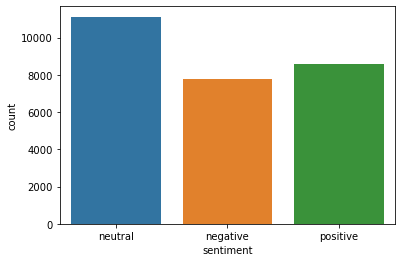

In [12]:
sns.countplot(x='sentiment', data=train_data)

Not same amount of the sentiment, it could be effected the target result. We should make them in same size

In [13]:
x=train_data.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
x

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


In [14]:
from plotly import graph_objs as go

funnel_chart=go.Funnelarea(text=x.sentiment, values=x.text, title={"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"})
fig=go.Figure(funnel_chart)
fig.show()

And as we see, the neutral data is the biggest data in training data.

Python is sensitive for lower and upper word, so we are lowering all text

In [15]:
#lowering text
#train data
train_data['text']=train_data['text'].str.lower()
train_data['selected_text']=train_data['selected_text'].str.lower()

#test data
test_data['text']=test_data['text'].str.lower()

In [16]:
train_data

,textID,text,selected_text,sentiment
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband l...,d lost,negative
27477,4f4c4fc327,i`ve wondered about rake to. the client has ...,", don`t force",negative
27478,f67aae2310,yay good for both of you. enjoy the break - y...,yay good for both of you.,positive
27479,ed167662a5,but it was worth it ****.,but it was worth it ****.,positive


In [17]:
test_data

,textID,text,sentiment
0,f87dea47db,last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"recession hit veronique branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - i like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,416863ce47,all alone in this old house again. thanks for...,positive
3531,6332da480c,i know what you mean. my little dog is sinkin...,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive


We have seen that train data has selected_text and we still don't know what is it and it's correlation with text. From first few datas, we can see that selected_text is text itself for neutral sentiment, but we should check this hypotesis. For explore this, we use Jaccard score to mesure the similarities between two text. Jaccard score difined by below function

In [18]:
#dropping null row
train_copy=train_data.copy()
train_copy.dropna(inplace=True)

In [19]:
def jaccard(text1, text2):
    '''function for finding jaccard index'''
    set1=set(text1.split())
    set2=set(text2.split())
    set_in=set1 & set2
    return float(len(set_in))/(len(set1)+len(set2)-len(set_in))

In [20]:
def jaccard_generator(data):
    jaccard_result=[]
    for index, row in data.iterrows():
        sentence_text=row.text
        sentence_ST=row.selected_text
        jaccard_score=jaccard(sentence_text,sentence_ST)
        jaccard_result.append(jaccard_score)
    return jaccard_result

#adding jaccard_score column to train_data
train_copy['jaccard_score']=jaccard_generator(train_copy)
train_copy.head()

,textID,text,selected_text,sentiment,jaccard_score
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,0.214286


updated the train_data data frame by adding some new feature like number of text and selected_text, and the difference between of them

In [21]:
num_word_text=train_copy['text'].apply(lambda x: len(str(x).split()))
num_word_ST=train_copy['selected_text'].apply(lambda x: len(str(x).split()))
train_copy['difference_word']=num_word_text-num_word_ST
train_copy.head()

,textID,text,selected_text,sentiment,jaccard_score,difference_word
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,0
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,2
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,0.214286,11


let see the distribution of jaccard_score and difference_word based on sentiment

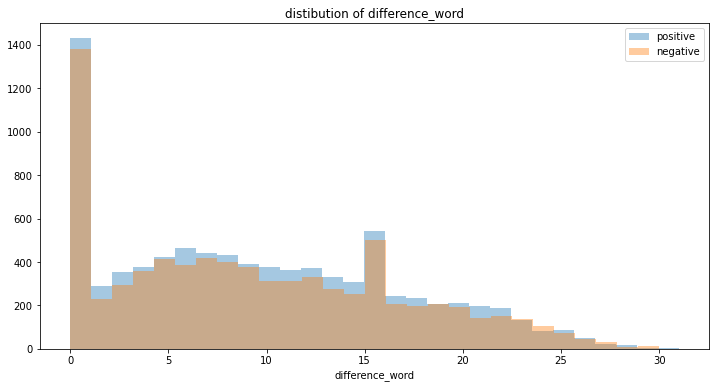

In [22]:
import matplotlib.pyplot as plt

#plot for distribution diffence_word based on sentiment
plt.figure(figsize=(12,6))
sns.distplot(train_copy[train_copy['sentiment']=='positive']['difference_word'],label='positive',kde=False)
sns.distplot(train_copy[train_copy['sentiment']=='negative']['difference_word'],label='negative',kde=False)

plt.title("distibution of difference_word")
plt.legend()

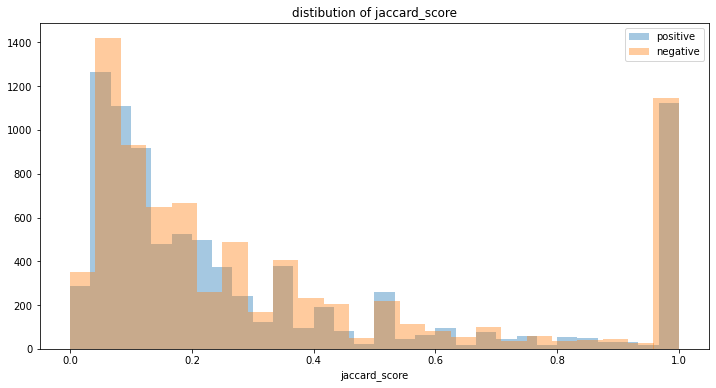

In [23]:
#plot for distribution jaccard_score based on sentiment

plt.figure(figsize=(12,6))
sns.distplot(train_copy[train_copy['sentiment']=='positive']['jaccard_score'],label='positive',kde=False)
sns.distplot(train_copy[train_copy['sentiment']=='negative']['jaccard_score'],label='negative',kde=False)

plt.title('distibution of jaccard_score')
plt.legend()

As figured by plot, we see there is nearly same distribution of difference_word and jaccard_score on negative and positive sentiment. 

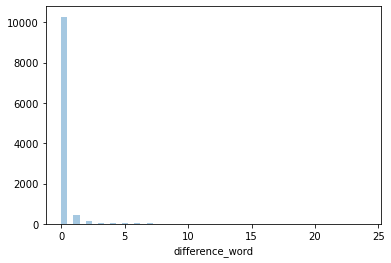

In [24]:
sns.distplot(train_copy[train_copy['sentiment']=='neutral']['difference_word'],label='neutral',kde=False)


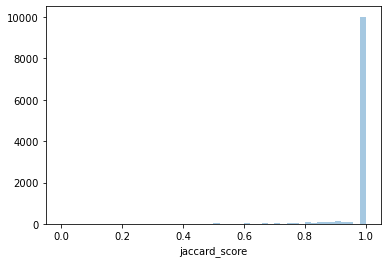

In [25]:
sns.distplot(train_copy[train_copy['sentiment']=='neutral']['jaccard_score'],label='neutral',kde=False)


In [26]:
train_copy[train_copy['sentiment']=='neutral'][train_copy['jaccard_score']<1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,textID,text,selected_text,sentiment,jaccard_score,difference_word
35,4f5267ad70,"thats it, its the end. tears for fears vs eric...","thats it, its the end. tears for fears",neutral,0.571429,6
57,6086b1f016,will be back later. http://plurk.com/p/rp3k7,will be back later.,neutral,0.800000,1
86,0c0563423e,miles from you i`m in essex so give me plen...,miles from you i`m in essex so give me plent...,neutral,0.920000,0
92,a3de81e1ba,hi how are you doing ??? *just joined twitt...,hi how are you doing ??? *just joined twitte...,neutral,0.800000,0
110,9c4817f73b,if u have a friendster add me!!!!!!!!! ...,if u have a friendster add me!!!!!!!!! ...,neutral,0.800000,3
...,...,...,...,...,...,...
27315,cad70bf44a,poor you if i was with you right now; i wou...,poor you if i was with you right now; i woul...,neutral,0.928571,1
27332,3a9d357027,haha i see im so bored rite now.. it seems li...,haha i see im so bored rite now.,neutral,0.368421,10
27349,f60f20ed09,"yea but that`s an old pic, she looks a lot d...","yea but that`s an old pic, she looks a lot di...",neutral,0.909091,0
27374,b49385ebb7,"says finally, im home. http://plurk.com/p/rr121","says finally, im home.",neutral,0.800000,1


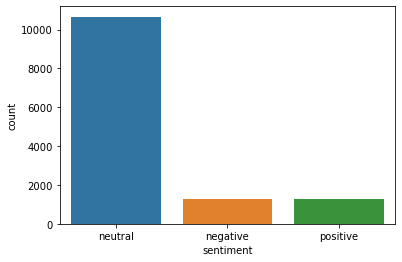

In [27]:
sns.countplot(x=train_copy['sentiment'][train_copy['jaccard_score']>0.8])

From this checking, selected_text is nearly same text. it conclusion comes from the jaccard_score is one or nearly one and the difference_word mostly on zero. many Neutral sentiment has jaccard score more than 0.8. So we can say neutral sentiment text and selected text are nearly same

**Most Frequent Word**

before we next to most frequent word, we need to clean the text from url, bracket, punctuation

In [28]:
#making copy of train data

import re

def cleaner(text):
    '''clean the text'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[^\w\s]' , '', text)
    text = re.sub('[%s]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train_copy['text']=train_copy['text'].apply(cleaner)
train_copy['selected_text']=train_copy['selected_text'].apply(cleaner)

train_copy

,textID,text,selected_text,sentiment,jaccard_score,difference_word
0,cb774db0d1,id have reponded if i were going,id have reponded if i were going,neutral,1.000000,0
1,549e992a42,ooo ad i will mi you here in an diego,ooo ad,negative,0.200000,8
2,088c60f138,my bo i bullying me,bullying me,negative,0.166667,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,2
4,358bd9e861,on of why couldnt they put them on the relea...,on of,negative,0.214286,11
...,...,...,...,...,...,...
27476,4eac33d1c0,wih we could come ee u on denver huband lot ...,d lot,negative,0.058824,14
27477,4f4c4fc327,ive wondered about rake to the client ha mad...,dont force,negative,0.083333,20
27478,f67aae2310,yay good for both of you enjoy the break you...,yay good for both of you,positive,0.272727,16
27479,ed167662a5,but it wa worth it,but it wa worth it,positive,1.000000,0


In [29]:
#remove stopword
from nltk.corpus import stopwords

def stopword_remover(text):
    stopword=stopwords.words('english')
    words=text.split(" ")
    result=[word for word in words if word not in stopword]
    return " ".join([word for word in result])

train_copy['text']=train_copy['text'].apply(stopword_remover)
train_copy['selected_text']=train_copy['selected_text'].apply(stopword_remover)
train_copy

,textID,text,selected_text,sentiment,jaccard_score,difference_word
0,cb774db0d1,id reponded going,id reponded going,neutral,1.000000,0
1,549e992a42,ooo ad mi diego,ooo ad,negative,0.200000,8
2,088c60f138,bo bullying,bullying,negative,0.166667,3
3,9642c003ef,interview leave alone,leave alone,negative,0.600000,2
4,358bd9e861,couldnt put releae already bought,,negative,0.214286,11
...,...,...,...,...,...,...
27476,4eac33d1c0,wih could come ee u denver huband lot hi job...,lot,negative,0.058824,14
27477,4f4c4fc327,ive wondered rake client ha made clear net d...,dont force,negative,0.083333,20
27478,f67aae2310,yay good enjoy break probably need uch hecti...,yay good,positive,0.272727,16
27479,ed167662a5,wa worth,wa worth,positive,1.000000,0


In [30]:
from collections import Counter

def common_words(data, column):
    temp=data[column].str.split()
    count=Counter([item for sublist in temp for item in sublist if len([i for i in item])>3])
    count_data=pd.DataFrame(count.most_common(20))
    count_data.columns = ['Common_words','count']
    return count_data

#common word for selected_text
common_ST=common_words(train_copy,'selected_text')
common_ST

,Common_words,count
0,good,1252
1,love,971
2,happy,852
3,like,796
4,dont,765
5,thank,748
6,work,641
7,cant,613
8,time,612
9,going,592


In [31]:
import plotly.express as px
fig = px.treemap(common_ST, path=['Common_words'], values='count',title='Tree Of Most Common Words')
fig.show()

Now we check the common word for each sentiment

In [32]:
positive=train_copy[train_copy['sentiment']=='positive']
positive_common=common_words(positive, 'selected_text')
fig = px.treemap(positive_common, path=['Common_words'], values='count',title='Tree Of Most Common Words')
fig.show()

In [33]:
negative=train_copy[train_copy['sentiment']=='negative']
negative_common=common_words(negative, 'selected_text')
fig = px.treemap(negative_common, path=['Common_words'], values='count',title='Tree Of Most Common Words')
fig.show()

In [34]:
neutral=train_copy[train_copy['sentiment']=='neutral']
neutral_common=common_words(neutral, 'selected_text')
fig = px.treemap(neutral_common, path=['Common_words'], values='count',title='Tree Of Most Common Words')
fig.show()

# Load Libraries, Data, Tokenizer
We will use HuggingFace transformers [here][1]

[1]: https://huggingface.co/transformers/

In [35]:
MAX_LEN = 96
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
EPOCHS = 5 # originally 3
BATCH_SIZE = 32 # originally 32
PAD_ID = 1
SEED = 88888
LABEL_SMOOTHING = 0.1
tf.random.set_seed(SEED)
np.random.seed(SEED)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = train_data[['textID','text','selected_text','sentiment']].fillna('')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative


In [36]:
train[train['text'].isna()]

,textID,text,selected_text,sentiment


# Training Data
We will now convert the training data into arrays that roBERTa understands. Here are example inputs and targets: 
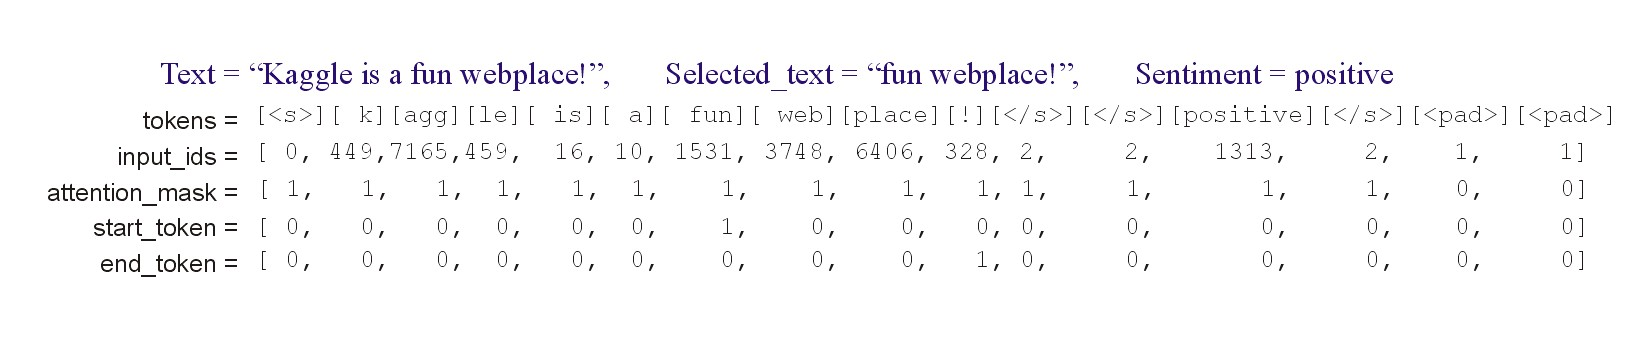
The tokenization logic below is inspired by Abhishek's PyTorch notebook [here][1].

[1]: https://www.kaggle.com/abhishek/roberta-inference-5-folds

In [37]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask[k,:len(enc.ids)+3] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+2] = 1
        end_tokens[k,toks[-1]+2] = 1

# Test Data
We must tokenize the test data exactly the same as we tokenize the training data

In [38]:
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask_t[k,:len(enc.ids)+3] = 1

# Build roBERTa Model
We use a pretrained roBERTa base model and add a custom question answer head. First tokens are input into `bert_model` and we use BERT's first output, i.e. `x[0]` below. These are embeddings of all input tokens and have shape `(batch_size, MAX_LEN, 768)`. Next we apply `tf.keras.layers.Conv1D(filters=1, kernel_size=1)` and transform the embeddings into shape `(batch_size, MAX_LEN, 1)`. We then flatten this and apply `softmax`, so our final output from `x1` has shape `(batch_size, MAX_LEN)`. These are one hot encodings of the start tokens indicies (for `selected_text`). And `x2` are the end tokens indicies.

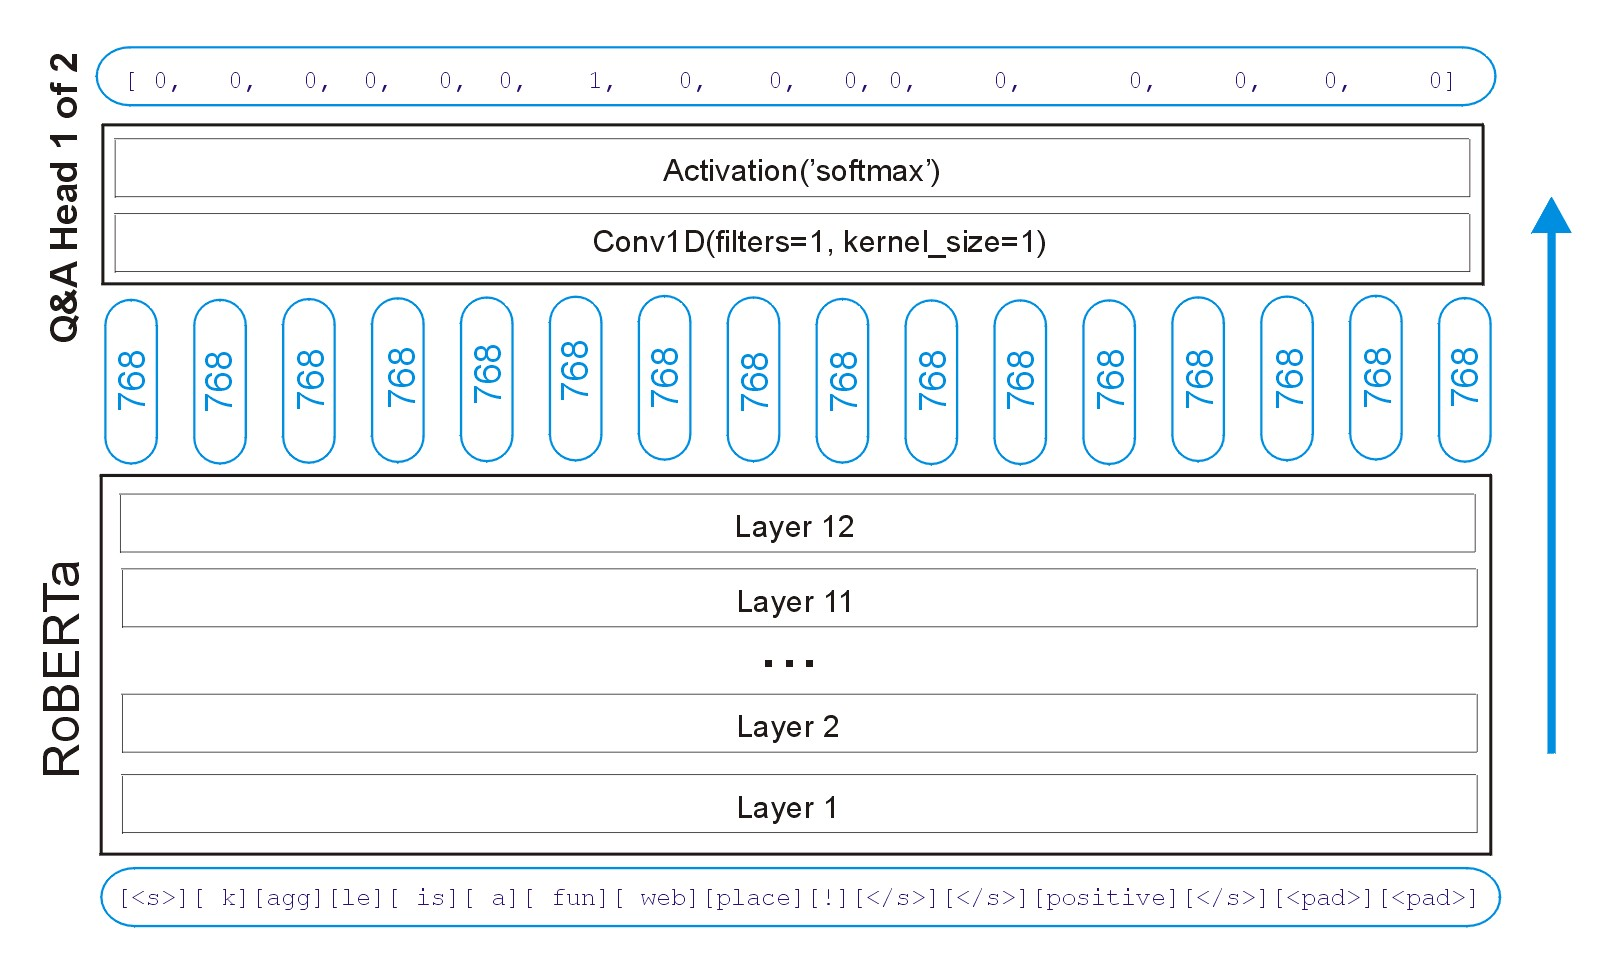

In [39]:
import pickle

def save_weights(model, dst_fn):
    weights = model.get_weights()
    with open(dst_fn, 'wb') as f:
        pickle.dump(weights, f)


def load_weights(model, weight_fn):
    with open(weight_fn, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    return model

def loss_fn(y_true, y_pred):
    # adjust the targets for sequence bucketing
    ll = tf.shape(y_pred)[1]
    y_true = y_true[:, :ll]
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred,
        from_logits=False, label_smoothing=LABEL_SMOOTHING)
    loss = tf.reduce_mean(loss)
    return loss


def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    padding = tf.cast(tf.equal(ids, PAD_ID), tf.int32)

    lens = MAX_LEN - tf.reduce_sum(padding, -1)
    max_len = tf.reduce_max(lens)
    ids_ = ids[:, :max_len]
    att_ = att[:, :max_len]
    tok_ = tok[:, :max_len]

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids_,attention_mask=att_,token_type_ids=tok_)
    
    x1 = tf.keras.layers.Dropout(0.2)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2,padding='same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.2)(x[0]) 
    x2 = tf.keras.layers.Conv1D(768, 2,padding='same')(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
    model.compile(loss=loss_fn, optimizer=optimizer)
    
    # this is required as `model.predict` needs a fixed size!
    x1_padded = tf.pad(x1, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    x2_padded = tf.pad(x2, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    
    padded_model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1_padded,x2_padded])
    return model, padded_model

# Metric

In [40]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Train roBERTa Model
We train with 5 Stratified KFolds (based on sentiment stratification). Each fold, the best model weights are saved and then reloaded before oof prediction and test prediction. Therefore you can run this code offline and upload your 5 fold models to a private Kaggle dataset. Then run this notebook and comment out the line `model.fit()`. Instead your notebook will load your model weights from offline training in the line `model.load_weights()`. Update this to have the correct path. Also make sure you change the KFold seed below to match your offline training. Then this notebook will proceed to use your offline models to predict oof and predict test.

In [41]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED) #originally 5 splits
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model, padded_model = build_model()
        
    #sv = tf.keras.callbacks.ModelCheckpoint(
    #    '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
    #    save_weights_only=True, mode='auto', save_freq='epoch')
    inpT = [input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]]
    targetT = [start_tokens[idxT,], end_tokens[idxT,]]
    inpV = [input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]]
    targetV = [start_tokens[idxV,], end_tokens[idxV,]]
    # sort the validation data
    shuffleV = np.int32(sorted(range(len(inpV[0])), key=lambda k: (inpV[0][k] == PAD_ID).sum(), reverse=True))
    inpV = [arr[shuffleV] for arr in inpV]
    targetV = [arr[shuffleV] for arr in targetV]
    weight_fn = '%s-roberta-%i.h5'%(VER,fold)
    for epoch in range(1, EPOCHS + 1):
        # sort and shuffle: We add random numbers to not have the same order in each epoch
        shuffleT = np.int32(sorted(range(len(inpT[0])), key=lambda k: (inpT[0][k] == PAD_ID).sum() + np.random.randint(-3, 3), reverse=True))
        # shuffle in batches, otherwise short batches will always come in the beginning of each epoch
        num_batches = math.ceil(len(shuffleT) / BATCH_SIZE)
        batch_inds = np.random.permutation(num_batches)
        shuffleT_ = []
        for batch_ind in batch_inds:
            shuffleT_.append(shuffleT[batch_ind * BATCH_SIZE: (batch_ind + 1) * BATCH_SIZE])
        shuffleT = np.concatenate(shuffleT_)
        # reorder the input data
        inpT = [arr[shuffleT] for arr in inpT]
        targetT = [arr[shuffleT] for arr in targetT]
        model.fit(inpT, targetT, 
            epochs=epoch, initial_epoch=epoch - 1, batch_size=BATCH_SIZE, verbose=DISPLAY, callbacks=[],
            validation_data=(inpV, targetV), shuffle=False)  # don't shuffle in `fit`
        save_weights(model, weight_fn)

    print('Loading model...')
    # model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    load_weights(model, weight_fn)

    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = padded_model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = padded_model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-2:b-1])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

#########################
### FOLD 1
#########################
Train on 21984 samples, validate on 5497 samples
21984/21984 [==============================] - 122s 6ms/sample - loss: 2.9023 - activation_loss: 1.4522 - activation_1_loss: 1.4502 - val_loss: 2.5486 - val_activation_loss: 1.2848 - val_activation_1_loss: 1.2649
Train on 21984 samples, validate on 5497 samples
Epoch 2/2
21984/21984 [==============================] - 102s 5ms/sample - loss: 2.5431 - activation_loss: 1.2890 - activation_1_loss: 1.2541 - val_loss: 2.5081 - val_activation_loss: 1.2796 - val_activation_1_loss: 1.2295
Train on 21984 samples, validate on 5497 samples
Epoch 3/3
21984/21984 [==============================] - 101s 5ms/sample - loss: 2.4578 - activation_loss: 1.2453 - activation_1_loss: 1.2125 - val_loss: 2.5192 - val_activation_loss: 1.2702 - val_activation_1_loss: 1.2501
Train on 21984 samples, validate on 5497 samples
Epoch 4/4
21984/21984 [==============================] - 102s 5ms/sample - loss: 2

In [42]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))

>>>> OVERALL 5Fold CV Jaccard = 0.7013126159340856


In [43]:
print(jac) # Jaccard CVs

[0.7063923293040545, 0.7065884073830357, 0.6991091588174313, 0.6974100853894647, 0.6970630987764416]


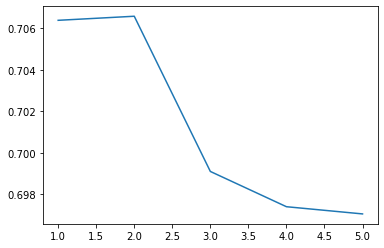

In [44]:
sns.lineplot(x=[1,2,3,4,5],y=jac)

# Kaggle Submission

In [45]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-2:b-1])
    all.append(st)

In [46]:
test['selected_text']=all
prediction=test[['textID','text','selected_text', 'sentiment']]

prediction.head()

,textID,text,selected_text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,exciting,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",such a shame!,negative
3,01082688c6,happy bday!,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,i like it!!,positive


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



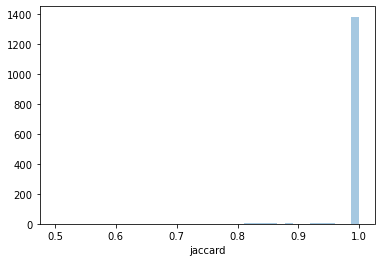

In [47]:
prediction['jaccard']=jaccard_generator(prediction)
sns.distplot(prediction[prediction['sentiment']=='neutral']['jaccard'],label='neutral',kde=False)


In [48]:
prediction[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)